In [1]:
from dolfin import *
import numpy as np
import ufl, time, meshio, pygmsh
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
model = "stress_cdf"
# model = "strain_cdf"
is_adaptive = True


In [3]:
comm = MPI.comm_world  # MPI communicator

mesh = Mesh()
with XDMFFile(comm, "mesh/ice-ad.xdmf") as infile:
    infile.read(mesh)

In [4]:
# Output the minimum element size
min_element_size = mesh.hmin()
print("Minimum element size: {:.4f}".format(min_element_size))

Minimum element size: 2.3329


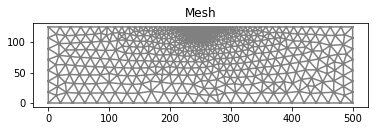

In [5]:
# Plot the mesh
plot(mesh,title='Mesh')
plt.show()

In [6]:
mesh

In [7]:

xdmf = XDMFFile(comm, "output/solution-ad-ice.xdmf")
xdmf.parameters["functions_share_mesh"] = True
xdmf.parameters["rewrite_function_mesh"] = True
xdmf.parameters["flush_output"] = True

In [8]:
hs_ratio = 0.0  # water level in crevasse (normalized with crevasse height)
hw_ratio = 0.0  # water level at right terminus (normalized with glacier thickness)
prec_ratio = 0.08  # depth of pre-crack (normalized with glacier thickness)
# energy_thsd = 0.6348 #62.94  # 
energy_thsd= 50 #62.94  # 0.5 is 4  Rock-2, Ice 25

# energy_thsd = 6.294
# energy_thsd = 0


L, H = 500, 125

In [9]:
# ---------------------------------------------------------------------------------
# MATERIAL PARAMETERS     ------------------------------------------------
# ---------------------------------------------------------------------------------

# rho_ice = 917  # density of ice (kg/m^3)
rho_H2O = 1000  # density of freshwater (kg/m^3)
rho_sea = 1020  # density of seawater (kg/m^3)
grav = 9.81  # gravity acceleration (m/s**2)


E = 9.5e9  # Young's modulus (Pa)
nu = 0.35  # Poisson's ratio
KIc = 0.1e6  # critical stress intensity factor (Pa*m^0.5)
rho_ice = 917  # density of ice (kg/m^3)


# E = 40e9*0.7  # Young's modulus (Pa)
# nu = 0.25  # Poisson's ratio
# rho_ice = 3000  # density of ice (kg/m^3)
# KIc = 1.15e6*0.7  # critical stress intensity factor (Pa*m^0.5)


mu = E / 2 / (1 + nu)  # shear modulus
K = E / 3 / (1 - 2 * nu)  # bulk modulus
lmbda = K - 2 / 3 * mu  # Lame's first parameter
lc = 0.625  # nonlocal length scale (m)
# lc = 0.1  # nonlocal length scale (m)
# eta = 5e1  # viscous regularization parameter (N*s/m)
# eta = 0.0
g1c = (KIc**2) * (1 - nu**2) / E  # critical strain energy release rate (Pa*m)
g2c = (
    10 * g1c
)  # assumed critical strain energy release rate for mode II fracture (Pa*m)
hw = hw_ratio * H  # water level at terminus (absolute height)
ci = 1

# sigmac = np.sqrt((1-nu**2)*KIc**2/lc)
# print(sigmac)
sigmac = 0.1185e6  # critical stress only for stress based method

In [10]:
l = lc

In [11]:
target_hmin = lc/3
ms_tol = 1e-3

In [12]:
target_hmin

0.20833333333333334

In [13]:
# Y0 = sigmac**2/(2*E) #Limiting crack driving energy
# energy_thsd = Y0
Y0 = sigmac**2/(2*E)*(1+energy_thsd)

In [14]:
# ---------------------------------------------------------------------------------
# SIMULATION PARAMETERS        ------------------------------------------------
# ---------------------------------------------------------------------------------
time_elapsed = 0
time_total = 500  # arbitrary
delta_t = 1.0  # time increment
time_counter = 0
output_increment = 5

Dcr = 0.6
air, water, ice = 0, 1, 2
water_left, water_right = 3, 4
right = 2

# ---------------------------------------------------------------------------------
# PARAMETERS FOR PARALLEL COMPUTATIONS   -----------------------------
# ---------------------------------------------------------------------------------


rank = comm.Get_rank()  # number of current process
size = comm.Get_size()  # total number of processes


def mwrite(filename, my_list):
    MPI.barrier(comm)
    if rank == 0:
        with open(filename, "w") as f:
            for item in my_list:
                f.write("%s" % item)


def mprint(*argv):
    if rank == 0:
        out = ""
        for arg in argv:
            out = out + str(arg)
        # this forces program to output when run in parallel
        print(out, flush=True)



In [15]:
# ---------------------------------------------------------------------------------
# SET SOME COMMON FENICS FLAGS     ---------------------------------------
# ---------------------------------------------------------------------------------
set_log_level(50)
parameters["form_compiler"]["optimize"] = True
parameters["form_compiler"]["cpp_optimize"] = True



In [16]:

# ---------------------------------------------------------------------------------
# MATERIAL MODEL  --------------------------------------------------------
# ---------------------------------------------------------------------------------
def epsilon(u):
    return 0.5 * (grad(u) + grad(u).T)


def sigma(u):
    return 2.0 * mu * epsilon(u) + lmbda * tr(epsilon(u)) * Identity(len(u))

In [17]:

# ---------------------------------------------------------------------------------
# ICE FRACTURE     --------------------------------------------------------
# ---------------------------------------------------------------------------------
def get_crack_tip_coord(dmg, damage_threshold=0.6):
    dmg_dg_1 = project(dmg, D)
    coord_vec = y_co_ord.vector()[dmg_dg_1.vector()[:] >= damage_threshold]
    coord = 115  # ToDo: Change this
    if coord_vec.size > 0:
        coord = coord_vec.min()
    return MPI.min(comm, coord)


# As the crack will propogate it will change the crevasse depth
# Thus, I have to make a mesh function that will update the zones
# of air, water and ice

# Start with complete ice.
# Mark the zone where damage is > Dcr as air
# Mark the water zone


def get_density_mf(dmg, Dcr=0.6):
    # ---------------------------------------------------------------------------------
    V = VectorFunctionSpace(mesh, "CG", 1)  # displacement shape function
    D = FunctionSpace(mesh, "CG", 1)  # phase-field shape function
    D1 = FunctionSpace(mesh, "DG", 0)  # phase-field shape function
    D2 = FunctionSpace(mesh, "DG", 1)  # phase-field shape function
    dmg = project(dmg, D1)
    density_mf = MeshFunction("size_t", mesh, 2)
    density_mf.set_all(ice)
    density_mf.array()[dmg.vector()[:] > Dcr] = air
    crevasse_depth, water_surface_from_bottom = surface_crevasse_level(dmg)
    water_zone = Function(D1)
    water_zone.interpolate(
        Expression(
            "x[1]>zs && x[1]<wl?1:0",
            zs=H - crevasse_depth,
            wl=water_surface_from_bottom,
            degree=1,
        )
    )

    density_mf.array()[
        np.multiply(dmg.vector()[:] > Dcr, water_zone.vector()[:] > 0)
    ] = water
    density_mf.array()
    return density_mf


def surface_crevasse_level(dmg):
    # We have to figure out the crevasse_depth from top and the
    # crevasse_surface from bottom. We have the damage function
    x2_dmg_min = get_crack_tip_coord(dmg, damage_threshold=0.99)
    crevasse_depth = H - x2_dmg_min
    water_surface_from_bottom = crevasse_depth * hs_ratio + x2_dmg_min
    return crevasse_depth, water_surface_from_bottom

In [18]:
# ---------------------------------------------------------------------------------
# ENERGY CALCULATIONS        ------------------------------------------------
# ---------------------------------------------------------------------------------
def applyElementwise(f, T):
    sh = ufl.shape(T)
    if len(sh) == 0:
        return f(T)
    fT = []
    for i in range(0, sh[0]):
        fT += [applyElementwise(f, T[i])]
    return as_tensor(fT)


def split_plus_minus(T):
    x_plus = applyElementwise(lambda x: 0.5 * (abs(x) + x), T)
    x_minus = applyElementwise(lambda x: 0.5 * (abs(x) - x), T)
    return x_plus, x_minus


def safeSqrt(x):
    return sqrt(x + DOLFIN_EPS)


def principal_tensor(t):
    eig1 = 0.5 * (tr(t) + safeSqrt(tr(t) * tr(t) - 4 * det(t)))
    eig2 = 0.5 * (tr(t) - safeSqrt(tr(t) * tr(t) - 4 * det(t)))
    return as_tensor([[eig1, 0], [0, eig2]])

def get_psi(unew):
    dim = unew.function_space().mesh().topology().dim()
    strain = epsilon(unew)
    if dim == 1:
        principal_strain = strain
    else:
        principal_strain = get_eigenstate(strain)
        strain_plus, strain_minus = split_plus_minus(principal_strain)
        tr_pr_strain = tr(principal_strain)
        tr_pr_str_plus, tr_pr_str_minus = split_plus_minus(tr_pr_strain)
        si_plus = lmbda / 2 * (tr_pr_str_plus ** 2) + mu * (inner(strain_plus, strain_plus))
    return si_plus

# -----------------------------------------------------------------------------
# 2D eigen decomposition
# -----------------------------------------------------------------------------

def get_eigenstate(t):
    eig1 = 0.5 * (tr(t) + safeSqrt(tr(t) * tr(t) - 4 * det(t)))
    eig2 = 0.5 * (tr(t) - safeSqrt(tr(t) * tr(t) - 4 * det(t)))
    return as_tensor([[eig1, 0], [0, eig2]])

def get_energy(unew,pnew,D):
    if model == "stress_cdf":
        # stress_plus, stress_minus = split_plus_minus(get_eigenstate(sigma(unew)))
        stress_plus = get_eigenstate(sigma(unew))
        energy_expr = ci * ((ufl.Max(stress_plus[0, 0],0)**2 + ufl.Max(stress_plus[1, 1],0)**2)/sigmac ** 2  - 1)
        energy_expr = ufl.Max(energy_expr, 0)
        energy_expr = ufl.conditional(ufl.le(energy_expr, energy_thsd), 0, energy_expr)
        energy = project(energy_expr, D, solver_type="cg",
                        preconditioner_type="hypre_euclid").vector()[:]
    else:
        eig = get_eigenstate(epsilon(unew))
        eig_1, eig_2 = eig[0, 0], eig[1, 1]

        # Define the energy function
        energy_expr = ufl.conditional(
            ufl.ge(eig_2, 0),
            (0.5 * lmbda * (eig_1 + eig_2) ** 2 + mu * (eig_1**2 + eig_2**2)) / g1c,
            ufl.conditional(
                ufl.And(ufl.ge(eig_1, 0), ufl.le(eig_2, 0)),
                conditional(
                    ufl.gt((1 - nu) * eig_1 + nu * eig_2, 0),
                    (0.5 * lmbda / nu / (1 - nu) * ((1 - nu) * eig_1 + nu * eig_2) ** 2)
                    / g1c,
                    0,
                ),
                0,
            ),
        )

    # Apply the threshold condition
        energy_expr = ufl.conditional(ufl.le(energy_expr, energy_thsd), 0, energy_expr)
        # https://fenicsproject.discourse.group/t/unable-to-use-conditional-module/6502
        energy = project(energy_expr, D).vector()[:]

    return energy




In [19]:
#  ▄▄       ▄▄  ▄▄▄▄▄▄▄▄▄▄▄  ▄▄▄▄▄▄▄▄▄▄▄  ▄▄        ▄
# ▐░░▌     ▐░░▌▐░░░░░░░░░░░▌▐░░░░░░░░░░░▌▐░░▌      ▐░▌
# ▐░▌░▌   ▐░▐░▌▐░█▀▀▀▀▀▀▀█░▌ ▀▀▀▀█░█▀▀▀▀ ▐░▌░▌     ▐░▌
# ▐░▌▐░▌ ▐░▌▐░▌▐░▌       ▐░▌     ▐░▌     ▐░▌▐░▌    ▐░▌
# ▐░▌ ▐░▐░▌ ▐░▌▐░█▄▄▄▄▄▄▄█░▌     ▐░▌     ▐░▌ ▐░▌   ▐░▌
# ▐░▌  ▐░▌  ▐░▌▐░░░░░░░░░░░▌     ▐░▌     ▐░▌  ▐░▌  ▐░▌
# ▐░▌   ▀   ▐░▌▐░█▀▀▀▀▀▀▀█░▌     ▐░▌     ▐░▌   ▐░▌ ▐░▌
# ▐░▌       ▐░▌▐░▌       ▐░▌     ▐░▌     ▐░▌    ▐░▌▐░▌
# ▐░▌       ▐░▌▐░▌       ▐░▌ ▄▄▄▄█░█▄▄▄▄ ▐░▌     ▐░▐░▌
# ▐░▌       ▐░▌▐░▌       ▐░▌▐░░░░░░░░░░░▌▐░▌      ▐░░▌
#  ▀         ▀  ▀         ▀  ▀▀▀▀▀▀▀▀▀▀▀  ▀        ▀▀


In [20]:
cpp_code = """
#include <pybind11/pybind11.h>
#include <dolfin/adaptivity/adapt.h>
#include <dolfin/function/Function.h>
#include <dolfin/mesh/Mesh.h>
namespace py = pybind11;
PYBIND11_MODULE(SIGNATURE, m)
{
m.def("adapt", [](const dolfin::Function &function,
          std::shared_ptr<const dolfin::Mesh> adapted_mesh,
                  bool interpolate){
             return dolfin::adapt(function, adapted_mesh, interpolate);});
}
"""
m = compile_cpp_code(cpp_code)


def adaptFunction(f, mesh, interp=True):
    return m.adapt(f, mesh, interp)

In [21]:
def transfer(_p, mesh):
    _p = Function(adaptFunction(_p._cpp_object, mesh))
    return _p

In [22]:
def estimate(cdf_old,cdf_new):
    DG = FunctionSpace(mesh, "DG", 0)
    error_estimate = project(cdf_new - cdf_old, DG).vector()[:]
    return error_estimate

def get_markers(marker_array, mesh, phi, Y0, cdf, alpa, target_hmin, psi):
    min_achieved = False
    DG = FunctionSpace(mesh, "DG", 0)

    marker = MeshFunction("bool", mesh, mesh.topology().dim())
    marker.set_all(False)
    # ---------------------------------------------------------------------------------
    # Scheme S1    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
    #  elements are refined, for which the value of error indicator is greater than α·max(error indicator)
    maximum_value = MPI.max(comm,max(marker_array))
    alpha_max = alpa * maximum_value
    marker.array()[marker_array > alpha_max] = True
    # ---------------------------------------------------------------------------------
    # Scheme S2    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
#     marker.array()[project(psi,DG).vector()[:] > 0.8*Y0] = True
    # marker.array()[project(psi,DG).vector()[:] < 0.8*Y0] = False
    # ---------------------------------------------------------------------------------
    # Scheme S3    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
    marker.array()[project(phi,DG).vector()[:] > 0.1] = True
    # ---------------------------------------------------------------------------------
    # Scheme S4    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
    cell_dia = Circumradius(mesh)
    
    dia_vector = project(cell_dia, DG, solver_type="cg",
        preconditioner_type="hypre_euclid").vector()[:]
    marker.array()[dia_vector < target_hmin] = False
    # ---------------------------------------------------------------------------------
    # ---------------------------------------------------------------------------------
    DG = None
    del DG

    min_achieved =    np.all(np.invert(marker.array()))
    return marker, min_achieved

In [23]:
D = FunctionSpace(mesh, "CG", 1)  # phase-field shape function
# --

y_co_ord = Function(D)
y_co_ord.interpolate(Expression("x[1]", degree=1))

In [24]:
def pff_problem(mesh,uold_adaptive, pold_adaptive, ms_step,cdf_old):
    # ---------------------------------------------------------------------------------
    V = VectorFunctionSpace(mesh, "CG", 1)  # displacement shape function
    DG = FunctionSpace(mesh, "DG", 0)  # phase-field shape function
    D = FunctionSpace(mesh, "CG", 1)  # phase-field shape function


    # ---------------------------------------------------------------------------------
   # ---------------------------------------------------------------------------------
    # BOUNDARIES AND MEASURES    ------------------------------------------------
    # ---------------------------------------------------------------------------------
    left = CompiledSubDomain("near(x[0], 0)")
    right_csd = CompiledSubDomain("near(x[0], L)", L=L)
    bottom = CompiledSubDomain("near(x[1], 0)")
    top = CompiledSubDomain("near(x[1], H)", H=H)

    bottom_roller = DirichletBC(V.sub(1), Constant(0), bottom)
    left_roller = DirichletBC(V.sub(0), Constant(0), left)

    disp_bc = [bottom_roller, left_roller]

    boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
    left.mark(boundaries, 1)
    right_csd.mark(boundaries, right)
    bottom.mark(boundaries, 3)
    top.mark(boundaries, 4)
    ds = Measure("ds", subdomain_data=boundaries)
    bc_phi = []
    # ---------------------------------------------------------------------------------
    # FUNCTIONS    --------------------------------------------------------------
    # ---------------------------------------------------------------------------------

    u, v = TrialFunction(V), TestFunction(V)
    p, q = TrialFunction(D), TestFunction(D)

    unew, uold = Function(V, name="displacement"), Function(V)
    pnew, pold = Function(D, name="damage"), Function(D)
    cdf = Function(DG, name='energy')

    # ---------------------------------------------------------------------------------
    # UPDATE FUNCTIONS    --------------------------------------------------------
    # ---------------------------------------------------------------------------------

    if step_counter > 0:
        pold.assign(project(pold_adaptive,D))
        uold.assign(project(uold_adaptive,V))

    # ---------------------------------------------------------------------------------
    # DISPLACEMENT PROBLEM      -----------------------------------------------
    # ---------------------------------------------------------------------------------
    # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    crevasse_depth, water_surface_from_bottom = surface_crevasse_level(pold)
#     dx = Measure("dx", subdomain_data=get_density_mf(pold))

    disp_a = inner(((1 - pold) ** 2 + 1e-4) * sigma(u), epsilon(v)) * dx
    disp_L = (1-pold)*inner(v, Constant((0, -rho_ice * grav))) * dx
#     disp_L = inner(v, Constant((0, -rho_ice * grav))) * dx



    # unew = Function(V, name="displacement")
    disp_problem = LinearVariationalProblem(disp_a, disp_L, unew, disp_bc)
    disp_solver = LinearVariationalSolver(disp_problem)

    prm_disp = disp_solver.parameters
    prm_disp["linear_solver"] = "gmres"
    prm_disp["preconditioner"] = "hypre_euclid"
    # ---------------------------------------------------------------------------------
    # PHASE FIELD PROBLEM      -----------------------------------------------
    # ---------------------------------------------------------------------------------
    phase_a = (l**2 * inner(grad(p), grad(q)) + (1) * inner(p, q)+ cdf * inner(p, q))*dx
    phase_L = inner(cdf, q) * dx 
    phase_problem = LinearVariationalProblem(phase_a, phase_L, pnew)
    phase_solver = LinearVariationalSolver(phase_problem)

    prm_phase = phase_solver.parameters
    prm_phase["linear_solver"] = "gmres"
    prm_phase["preconditioner"] = "hypre_euclid"
    # ---------------------------------------------------------------------------------
    # START ITERATIONS    -----------------------------------------------------
    # ---------------------------------------------------------------------------------
    disp_solver.solve()
    # update history variable --------------------------------------------------
    cdf.vector().vec().array[:] = np.maximum(get_energy(unew,pnew,DG)[:],cdf_old.vector()[:])
#     cdf.vector().vec().array[:] = get_energy(unew,pnew,D)[:]
    # ToDo: kappa = np.fmax(energy, kappa)
    phase_solver.solve()
    # Clip the damage solution to 0-1 ------------------------------------------
    pnew.vector().vec().array[:] = np.clip(pnew.vector()[:], 0, 1)
    # pnew will be max(pold,pnew)-----------------------------------------------
    # pnew.vector().vec().array[:] = np.maximum(pnew.vector()[:], pold.vector()[:])
    
    # update counter -----------------------------------------------------------
    # xdmf.write(unew, step_counter)
#     xdmf.write(pnew, step_counter)
    # xdmf.write(cdf, step_counter)

    # T = TensorFunctionSpace(mesh,"DG",0)
    # stress = Function(T, name="stress")
    # stress.assign(project(sigma(unew),T))
    # xdmf.write(stress, step_counter)

    err_u = sqrt(assemble((unew - uold)**2 * dx))
    err_phi = sqrt(assemble((pnew - pold)**2 * dx))
    ms_err = max(err_u, err_phi)
    # print("err - u - ", err_u, " -- err - phi - ", err_phi)
   

#     min_ms_achieved = False
#     if ms_err < ms_tol or ms_step>10:
    min_ms_achieved = True

#     if ms_err < ms_tol:
    
    return unew, pnew, cdf, min_ms_achieved, ms_err

False


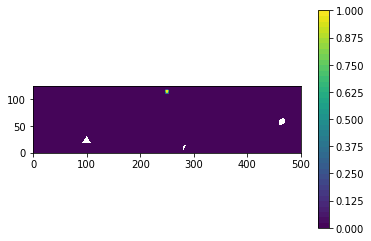

step:   0, cracktip_ratio:  0.098, hmin:  1.28, time:      1, cdf: 120.53, ms_error: 3.15334
False


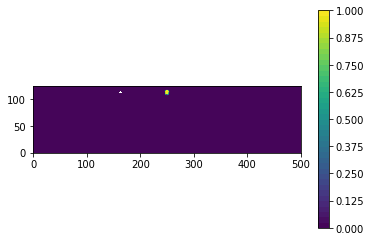

step:   1, cracktip_ratio:  0.098, hmin:  0.64, time:      1, cdf: 6760.96, ms_error: 2.44138
False


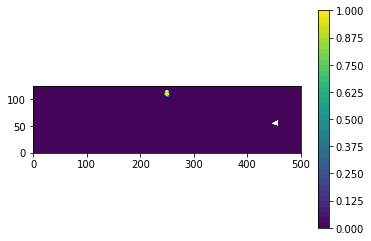

step:   2, cracktip_ratio:  0.146, hmin:  0.32, time:      2, cdf: 14350.06, ms_error: 3.50882
False


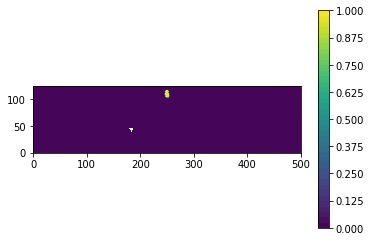

step:   3, cracktip_ratio:  0.146, hmin:  0.16, time:      2, cdf: 17619.92, ms_error: 2.89758
False


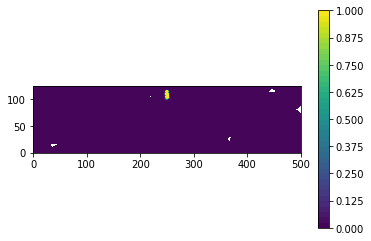

step:   4, cracktip_ratio:  0.180, hmin:  0.16, time:      3, cdf: 26742.39, ms_error: 3.32813
False


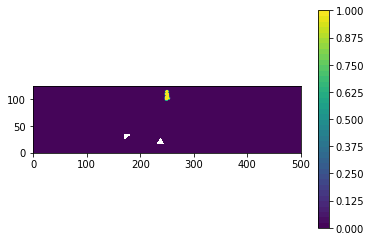

step:   5, cracktip_ratio:  0.210, hmin:  0.13, time:      4, cdf: 37605.66, ms_error: 3.43495
False


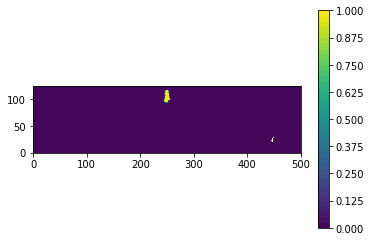

step:   6, cracktip_ratio:  0.210, hmin:  0.13, time:      4, cdf: 48953.90, ms_error: 3.58727
False


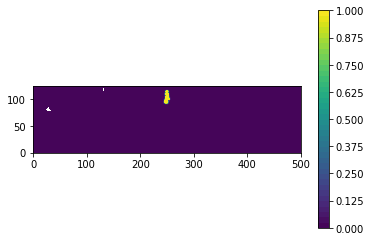

step:   7, cracktip_ratio:  0.249, hmin:  0.13, time:      5, cdf: 62666.76, ms_error: 3.63337
False


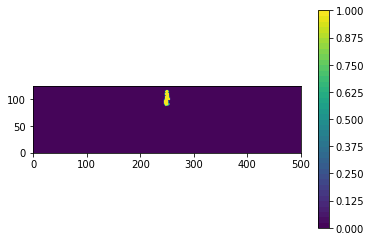

step:   8, cracktip_ratio:  0.249, hmin:  0.13, time:      7, cdf: 75832.20, ms_error: 4.02713
False


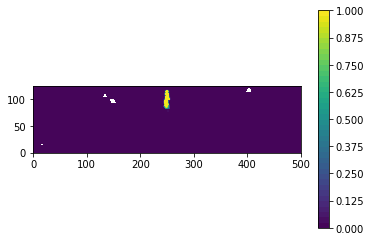

step:   9, cracktip_ratio:  0.302, hmin:  0.13, time:      8, cdf: 91571.97, ms_error: 4.49253
False


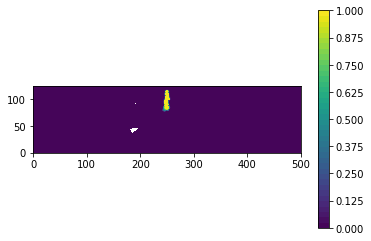

step:  10, cracktip_ratio:  0.349, hmin:  0.13, time:      9, cdf: 115430.00, ms_error: 4.14405
False


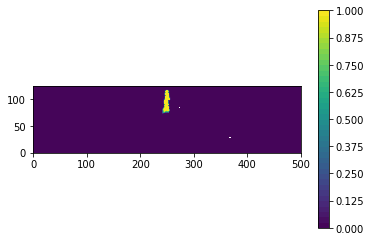

step:  11, cracktip_ratio:  0.349, hmin:  0.13, time:     10, cdf: 134265.40, ms_error: 4.51224
False


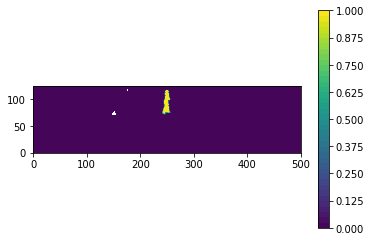

step:  12, cracktip_ratio:  0.349, hmin:  0.13, time:     12, cdf: 155201.14, ms_error: 3.09618
False


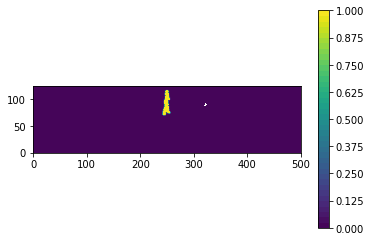

step:  13, cracktip_ratio:  0.349, hmin:  0.12, time:     14, cdf: 167588.44, ms_error: 3.33323
False


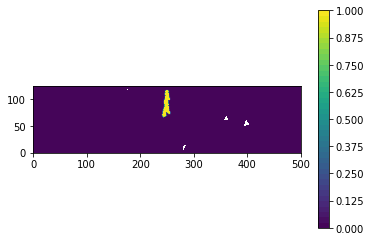

step:  14, cracktip_ratio:  0.349, hmin:  0.12, time:     16, cdf: 180859.74, ms_error: 3.35932
False


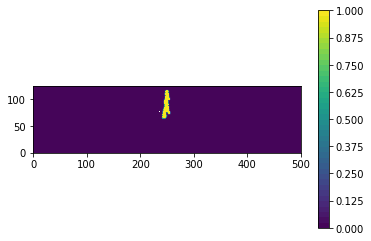

step:  15, cracktip_ratio:  0.349, hmin:  0.12, time:     18, cdf: 193843.73, ms_error: 3.58186
False


KeyboardInterrupt: 

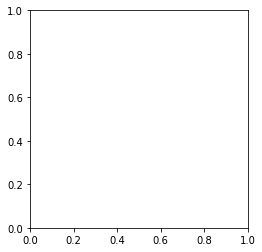

In [25]:
step_counter = 0
start = time.time()
# # ---------------------------------------------------------------------------------

# # --
# # ---------------------------------------------------------------------------------
D = FunctionSpace(mesh, "CG", 1)
V = VectorFunctionSpace(mesh, "CG", 1)
DG = FunctionSpace(mesh, "DG", 0)
# # --
# p_adaptive = Function(FunctionSpace(mesh, "CG", 1),name="damage" )
# unew = Function(VectorFunctionSpace(mesh, "CG", 1), name="displacement")
# cdf_old = Function(FunctionSpace(mesh, "DG", 0), name="energy")
# cdf_new = Function(FunctionSpace(mesh, "DG", 0), name="energy")

# psi_old = Function(FunctionSpace(mesh, "DG", 0), name="energy")
# psi_new = Function(FunctionSpace(mesh, "DG", 0), name="energy")

p_adaptive = Function(D,name="damage" )
unew = Function(V, name="displacement")
cdf_old = Function(DG, name="energy")
cdf_new = Function(DG, name="energy")

psi_old = Function(DG, name="energy")
psi_new = Function(DG, name="energy")


data_list = []
time_elapsed = 0
while time_elapsed < 100:
# while time_elapsed <= 10:
    min_ms_achieved=False
    ms_step = 0
    while not min_ms_achieved:
#     while ms_step < 1:
        # ---------------------------------------------------------------------------------
        # SOLVE      -----------------------------------------------
        # ---------------------------------------------------------------------------------
        unew, p_adaptive, cdf_new, min_ms_achieved, ms_err = pff_problem(mesh,unew, p_adaptive,ms_step,cdf_old)
        psi_new.assign(project(get_psi(unew),cdf_new.function_space()))
        ms_step +=1
        if is_adaptive:
            # ESTIMATE      ----------------------------------------------
            error_estimate = estimate(psi_old,psi_new)
            # MARK     -----------------------------------------------
            marker, min_achieved = get_markers(error_estimate, mesh, p_adaptive, Y0, cdf_new, alpa=0.6, target_hmin=target_hmin, psi=psi_new)
            # REFINE      -----------------------------------------------
            mesh = refine(mesh, marker)
            print(min_achieved)
     
        # TRANSFER      -----------------------------------------------
        # ---------------------------------------------------------------------------------
        p_adaptive.assign(transfer(p_adaptive, mesh))
        unew.assign(transfer(unew, mesh))
        cdf_old.assign(transfer(cdf_new, mesh))
        psi_old.assign(transfer(psi_new, mesh))
        
            # ---------------------------------------------------------------------------------
        # update counter -----------------------------------------------------------
        a = plot(p_adaptive)
        plt.colorbar(a)
        plt.show()
        
        xdmf.write(p_adaptive, time_elapsed)
        
        
        # ---------------------------------------------------------------------------------
        # update counter -----------------------------------------------------------

        cracktip_coor = get_crack_tip_coord(p_adaptive)
#         xdmf.write(unew, step_counter)
#         xdmf.write(p_adaptive, step_counter)
        mprint(
            "step: {0:3}, cracktip_ratio: {1:6.3f}, hmin: {2:5.2f}, time: {3:6.0f}, cdf: {4:6.2f}, ms_error: {5:6.5f}".format(
                time_elapsed,
                1 - cracktip_coor / H,
                MPI.min(comm,mesh.hmin()),
                time.time() - start,
                max(cdf_old.vector().vec().array[:]),
                ms_err
            )
        )
    step_counter += 1
#     xdmf.write(unew, time_elapsed)
#     xdmf.write(p_adaptive, time_elapsed)
    time_elapsed += 1
    


In [ ]:
with XDMFFile("output/Solution-ad-rock.xdmf") as file:
    file.write(p_adaptive) 

In [ ]:
min_achieved

In [ ]:
xdmf.write(p_adaptive, step_counter)

In [ ]:
plot(p_adaptive)

In [ ]:
print(mesh)

In [ ]:
# Plot the mesh
plot(mesh,title='Mesh')
plt.show()

In [ ]:
mesh.hmin()

In [ ]:
# ---------------------------------------------------------------------------------
V = VectorFunctionSpace(mesh, "CG", 1)  # displacement shape function
D1 = FunctionSpace(mesh, "CG", 1)  # phase-field shape function
D = FunctionSpace(mesh, "DG", 0)  # phase-field shape function
D2 = FunctionSpace(mesh, "DG", 1)  # phase-field shape function

# --

y_co_ord = Function(D2)
y_co_ord.interpolate(Expression("x[1]", degree=1))

mprint("Number of vertices      : {}".format(D1.dim()))
mprint("Number of cells         : {}".format(D.dim()))
mprint("Number of DoF           : {}".format(V.dim()))
mprint("Number of processes     : {}".format(size))
mprint("Number of DoF/process   : {}".format(int(V.dim() / size)))
mprint("-----------------------------------------------------")

In [ ]:
p = plot(p_adaptive)
plt.colorbar(p)


In [ ]:
Y0

In [ ]:
a = plot(psi_new)
plt.colorbar(a)
# plot.show()